# REPL Jupyter Notebook

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

## 1. Load Data

In [3]:
def get_feature(df):
    attrs = [
        'PERIODS', 'STATION_NAME', 'TRIP_ORGIN_STATION',
        'TRIP_DESTINATION_STATION', 'TRIP_DURATION_SEC',
        'SEGMENT_DIRECTION_NAME', 'PLANNED_ARRIVAL_PLATFORM',
        'OTHER_CAR1_ARRIVE', 'OTHER_CAR2_ARRIVE',
        'OTHER_CAR3_ARRIVE', 'OTHER_CAR4_ARRIVE',
        'OTHER_CAR5_ARRIVE', 'OTHER_CAR6_ARRIVE',
        'OTHER_CAR7_ARRIVE', 'CAR_PSNGLD_ARRIVE',
        'NODE_SEQ_ORDER', 'TPS_PLANNED_DWELL_TIME',
        'TIME_SLOT', 'DAY_OF_WEEK'
    ]
    return df[attrs]

def get_label(df, carid):
    labelid = 'CAR{}_PSNGLD_DEPART'.format(carid)
    return df[labelid]

In [4]:
dataset_list = []
month = 2
car_list = [1, 2, 3, 4, 5, 6, 7, 8]
for i in car_list:
    df = pd.read_csv('../data/Dart/2019{:>02d}/car{}.csv'.format(month, i))
    dataset = (get_feature(df), get_label(df, i))
    dataset_list.append(dataset)

In [6]:
df = dataset_list[0][0]
df.shape

(469791, 19)

## 2. Training and Evaluation

### 2.1. Training Respectively

In [7]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 12,
    'learning_rate': 0.01,
    'verbose':0
}
n_boost_round = 1000

In [8]:
for i, (feature, label) in enumerate(dataset_list):
    rmse = []
    for j in range(5):
        x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=0.1, random_state=j+1)
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=j+1)
        training_set = lgb.Dataset(x_train, y_train)
        valid_set = lgb.Dataset(x_valid, y_valid)
        valid_sets = [valid_set]
        
        model = lgb.train(params, training_set, n_boost_round, valid_sets, verbose_eval=False)
        
        ybar = model.predict(x_test)
        rmse.append(np.sqrt(mean_squared_error(y_test, ybar)))
        
    print('Car{} : {:.4f}\u00b1{:.4f}'.format(i+1, np.mean(rmse), np.std(rmse)))

Car1 : 451.6615±55.4045
Car2 : 483.5978±6.9380
Car3 : 501.8160±7.8174
Car4 : 489.0690±4.8791
Car5 : 493.8011±4.2741
Car6 : 497.0507±3.2776
Car7 : 539.7608±46.7272
Car8 : 380.8061±4.4885


## 2.2. Mixed Training

In [9]:
feature_list = []
label_list = []
for i, (feature, label) in enumerate(dataset_list):
    feature_list.append(feature)
    label_list.append(label)
feature = pd.concat(feature_list)
label = pd.concat(label_list)

In [11]:
rmse = [[] for i in car_list]
for j in range(5):
    x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=0.1, random_state=j+1)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=j+1)
    training_set = lgb.Dataset(x_train, y_train)
    valid_set = lgb.Dataset(x_valid, y_valid)
    valid_sets = [valid_set]
    
    model = lgb.train(params, training_set, n_boost_round, valid_sets, verbose_eval=False)
    
    for i in range(len(car_list)):
        x_train, x_test, y_train, y_test = train_test_split(feature_list[i], label_list[i], test_size=0.1, random_state=j+1)
        ybar = model.predict(x_test)
        rmse[i].append(np.sqrt(mean_squared_error(y_test, ybar)))

for i in range(len(car_list)):
    print('Car{}: {:.4f}\u00b1{:.4f}'.format(i+1, np.mean(rmse[i]), np.std(rmse[i])))

Car1: 492.4306±43.8690
Car2: 524.3699±13.0326
Car3: 527.9895±6.5208
Car4: 529.5585±7.0421
Car5: 537.8453±12.4501
Car6: 529.1327±7.1222
Car7: 606.2634±58.2592
Car8: 416.4916±2.4744


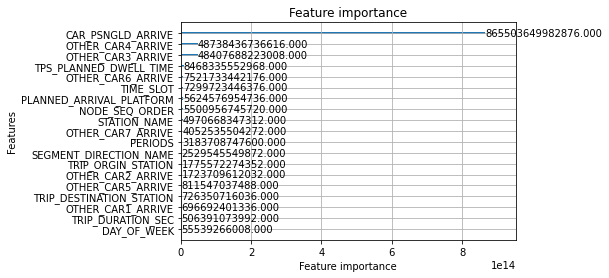

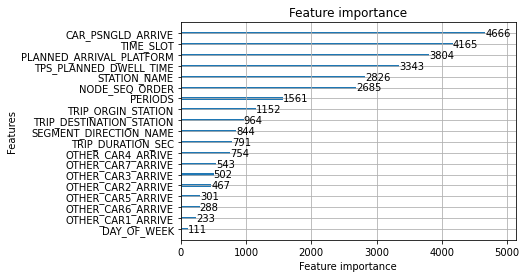

In [26]:
import matplotlib.pyplot as plt
lgb.plot_importance(model, importance_type='gain')
plt.show()

lgb.plot_importance(model, importance_type='split')
plt.show()

## 3. Data size study

In [5]:
from yaml import safe_load
import matplotlib.pyplot as plt

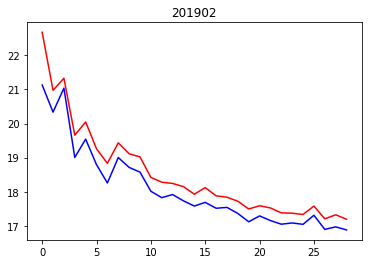

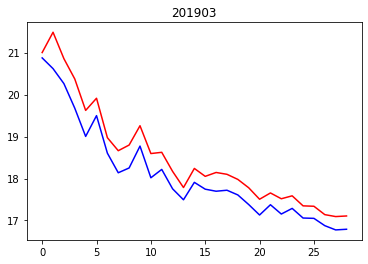

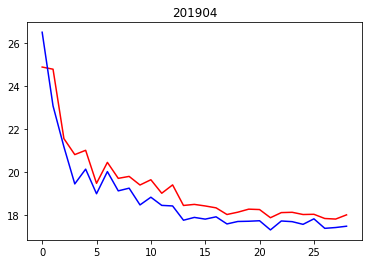

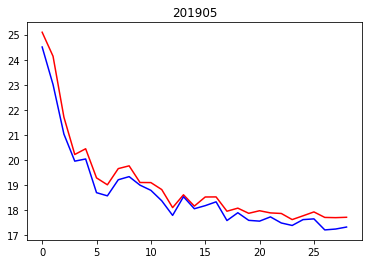

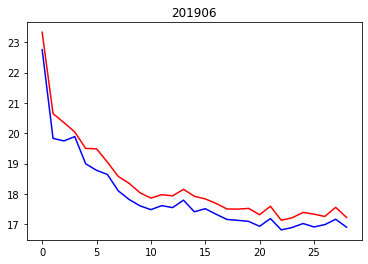

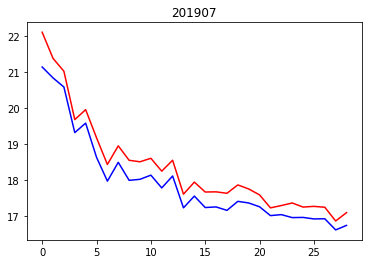

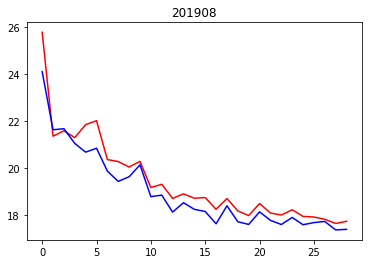

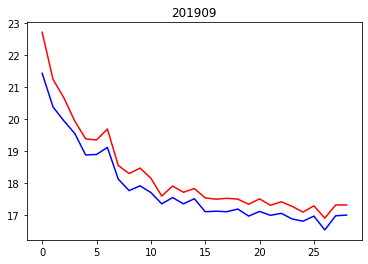

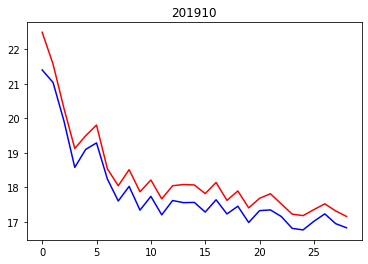

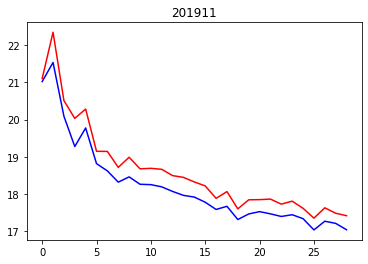

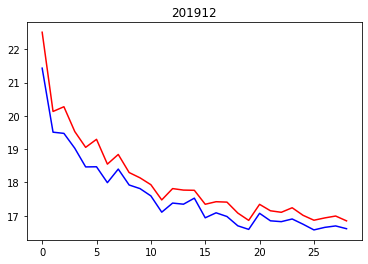

In [7]:
with open('../results.yml', 'r') as f:
    results = safe_load(f)
    
for month in range(1, 12):
    key1 = '2019{:>02d}'.format(month+1)
    mae1 = results[key1]['baseline']
    mae2 = results[key1]['mixed']
    plt.title(key1)
    plt.plot(mae1, color='r')
    plt.plot(mae2, color='b')
    plt.show()
    # 红色的是分别独立训练的结果
    # 蓝色的是混合在一起训练的结果